<a href="https://colab.research.google.com/github/fboldt/aulasml/blob/master/aula06a_%C3%A1rvore_de_decis%C3%A3o_atributos_cont%C3%ADnuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data
y = dataset.target

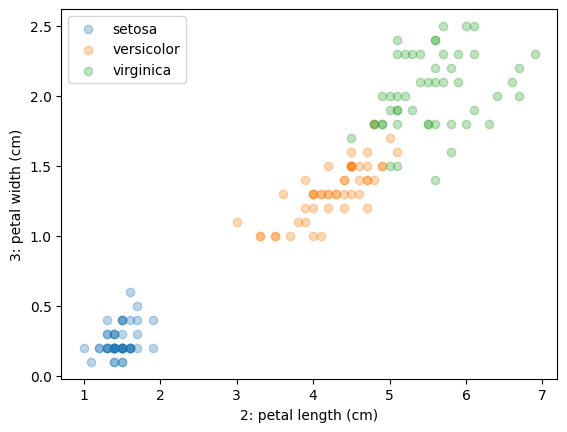

In [7]:
import matplotlib.pyplot as plt
i, j = 2, 3
def plot_features(i, j):
  plt.xlabel(f"{i}: {dataset.feature_names[i]}")
  plt.ylabel(f"{j}: {dataset.feature_names[j]}")
def plot_dataset(X, y):
  for k in set(y):
      plt.scatter(X[y == k, 0], X[y == k, 1], label=dataset.target_names[k], alpha=0.3)
plot_features(i, j)
plot_dataset(X[:,[i,j]], y)
plt.legend()
plt.show()

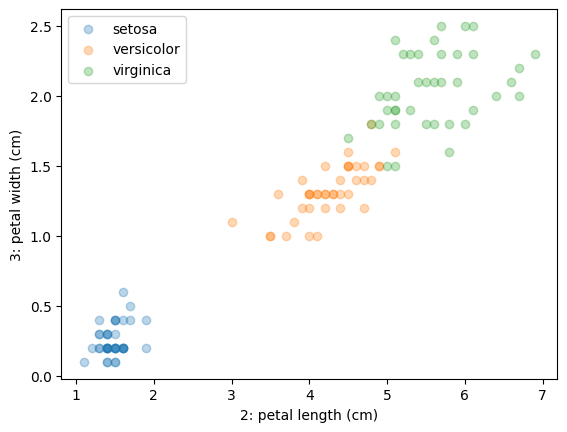

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:,[i,j]], y, test_size=0.2, random_state=42, stratify=y)
plot_features(i, j)
plot_dataset(X_train, y_train)
plt.legend()
plt.show()

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score

def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.answer = most_common(y)
    return self
  def predict(self, X):
    return [self.answer] * len(X)

model = ZeroR()
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))

0.3333333333333333


In [69]:
class DecisionTree(BaseEstimator, ClassifierMixin):
  def __init__(self, feature=0):
    self.feature = feature

  def fit(self, X, y):
    self.value = np.mean(X[:, self.feature])
    greater_values = X[:, self.feature] >= self.value
    if sum(greater_values)>0 and sum(~greater_values)>0:
      self.greaters = DecisionTree(self.feature).fit(X[greater_values], y[greater_values])
      self.lessers = DecisionTree(self.feature).fit(X[~greater_values], y[~greater_values])
    else:
      self.n_samples = len(y)
      self.answer = most_common(y)
    return self

  def predict(self, X):
    if hasattr(self, 'answer'):
      return np.array([self.answer] * len(X))
    else:
      greater_values = X[:, self.feature] >= self.value
      return np.where(greater_values, self.greaters.predict(X), self.lessers.predict(X))

model = DecisionTree()
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))

0.9


In [32]:
def defineAxes(X):
    offset = 0.1
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

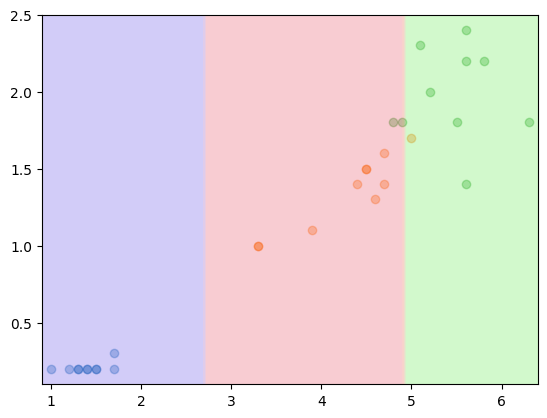

In [70]:
plot_dataset(X_test, y_test)
plotPredictions(model, X_test)
plt.show()

0.9333333333333333


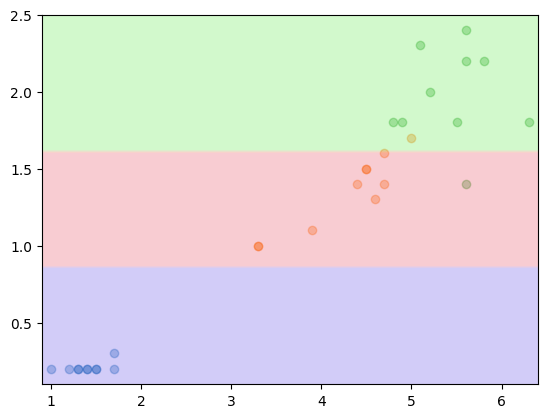

In [71]:
model = DecisionTree(1)
model.fit(X_train, y_train)
plot_dataset(X_test, y_test)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plotPredictions(model, X_test)
plt.show()

In [72]:
def print_tree(model, level=0):
  if hasattr(model, 'answer'):
    print('  '*level, f"answer: {model.answer} n={model.n_samples}")
  else:
    print('  '*level, f"feature: {model.feature}")
    print_tree(model.greaters, level+1)
    print_tree(model.lessers, level+1)

print_tree(model)


 feature: 1
   feature: 1
     feature: 1
       feature: 1
         feature: 1
           feature: 1
             answer: 2 n=3
             answer: 2 n=2
           answer: 2 n=7
         feature: 1
           answer: 2 n=1
           answer: 2 n=6
       feature: 1
         feature: 1
           answer: 2 n=5
           answer: 2 n=5
         answer: 2 n=8
     feature: 1
       feature: 1
         feature: 1
           answer: 2 n=1
           answer: 1 n=3
         answer: 1 n=10
       feature: 1
         answer: 1 n=5
         answer: 1 n=12
   feature: 1
     feature: 1
       feature: 1
         answer: 1 n=5
         answer: 1 n=2
       feature: 1
         answer: 1 n=5
         feature: 1
           answer: 0 n=1
           answer: 0 n=1
     feature: 1
       feature: 1
         answer: 0 n=7
         answer: 0 n=6
       feature: 1
         answer: 0 n=20
         answer: 0 n=5


In [73]:
def gini(y):
  labels = np.unique(y)
  tmp = 0
  for label in labels:
    p_label = np.mean(y == label)
    tmp += p_label**2
  return 1 - tmp

y_tmp = y[:]
gini_value = gini(y_tmp)
print(gini_value)

0.6666666666666667


In [74]:
def impurity_value(x, y, value, impurity_function=gini):
  greater_values = x >= value
  imp_greaters = impurity_function(y[greater_values])
  imp_lessers = impurity_function(y[~greater_values])
  return (sum(greater_values) / len(y)) * imp_greaters + \
         (sum(~greater_values) / len(y)) * imp_lessers

print(impurity_value(X_train[:, 0], y_train, 3.5))

0.34537408665225894


In [75]:
def best_split(x, y, impurity_function=gini):
  sx = sorted(x)
  best_imp = float('inf')
  best_value = sx[0]
  for i in range(len(sx)-1):
    value = (sx[i] + sx[i+1]) / 2
    imp = impurity_value(x, y, value, impurity_function)
    if imp < best_imp:
      best_imp = imp
      best_value = value
  return best_value, best_imp

print(best_split(X_train[:, 0], y_train))

(np.float64(2.45), np.float64(0.3333333333333333))


In [76]:
def best_feature(X, y, impurity_function=gini):
  best_imp = float('inf')
  best_feature = 0
  best_value = 0
  for feature in range(X.shape[1]):
    value, imp = best_split(X[:, feature], y, impurity_function)
    if imp < best_imp:
      best_imp = imp
      best_feature = feature
      best_value = value
  return best_feature, best_value, best_imp

print(best_feature(X_train, y_train))

(0, np.float64(2.45), np.float64(0.3333333333333333))


0.9333333333333333


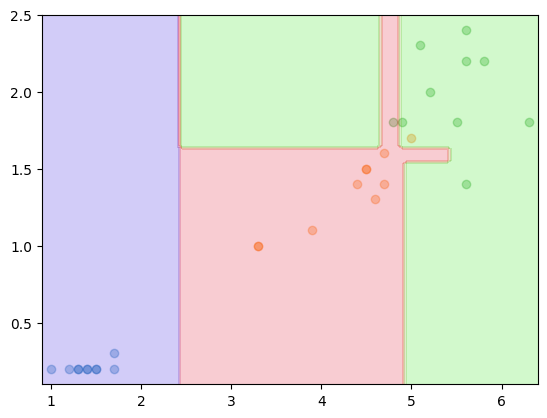

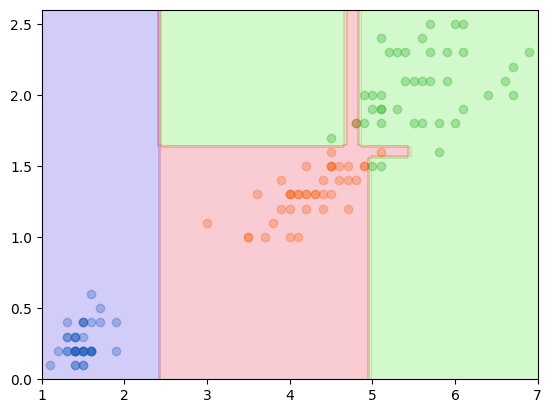

In [80]:
class DecisionTree(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.feature, self.value, self.imp  = best_feature(X, y)
    greater_values = X[:, self.feature] >= self.value
    if sum(greater_values)>0 and sum(~greater_values)>0:
      self.greaters = DecisionTree().fit(X[greater_values], y[greater_values])
      self.lessers = DecisionTree().fit(X[~greater_values], y[~greater_values])
    else:
      self.n_samples = len(y)
      self.answer = most_common(y)
    return self

  def predict(self, X):
    if hasattr(self, 'answer'):
      return np.array([self.answer] * len(X))
    else:
      greater_values = X[:, self.feature] >= self.value
      return np.where(greater_values, self.greaters.predict(X), self.lessers.predict(X))

model = DecisionTree()
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_dataset(X_test, y_test)
plotPredictions(model, X_test)
plt.show()
plot_dataset(X_train, y_train)
plotPredictions(model, X_train)
plt.show()

In [81]:
print_tree(model)

 feature: 0
   feature: 1
     feature: 0
       answer: 2 n=35
       feature: 0
         answer: 1 n=2
         answer: 2 n=1
     feature: 0
       feature: 1
         feature: 0
           answer: 2 n=1
           answer: 1 n=1
         feature: 0
           answer: 2 n=1
           answer: 2 n=1
       feature: 0
         answer: 1 n=37
         answer: 1 n=1
   feature: 0
     feature: 0
       answer: 0 n=38
       answer: 0 n=1
     answer: 0 n=1


0.9666666666666667


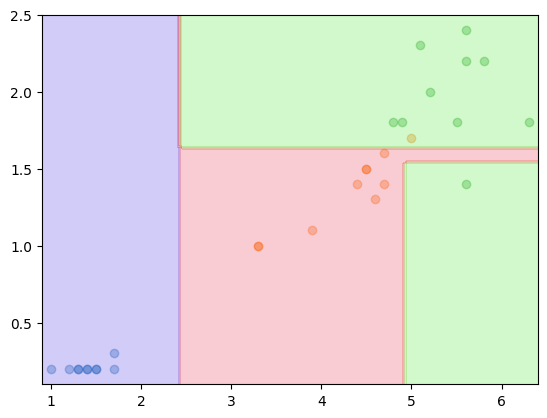

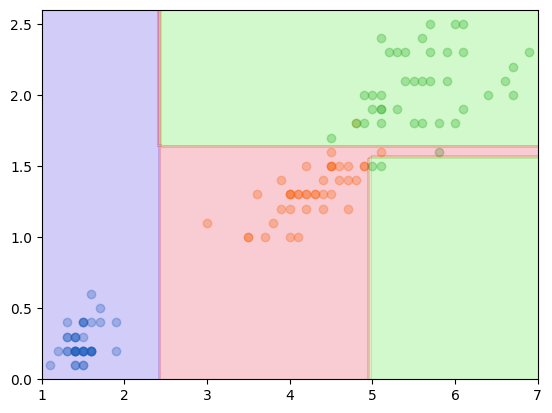

 feature: 0
   feature: 1
     feature: 0
       answer: 2 n=35
       answer: 2 n=3
     feature: 0
       feature: 1
         answer: 1 n=2
         answer: 2 n=2
       answer: 1 n=38
   answer: 0 n=40


In [106]:
class DecisionTree(BaseEstimator, ClassifierMixin):
  def __init__(self, min_samples_leaf=2):
    self.min_samples_leaf = min_samples_leaf

  def fit(self, X, y):
    self.feature, self.value, self.imp  = best_feature(X, y)
    greater_values = X[:, self.feature] >= self.value
    if sum(greater_values)>=self.min_samples_leaf and \
       sum(~greater_values)>=self.min_samples_leaf:
      self.greaters = DecisionTree(min_samples_leaf=self.min_samples_leaf).fit(X[greater_values], y[greater_values])
      self.lessers = DecisionTree(min_samples_leaf=self.min_samples_leaf).fit(X[~greater_values], y[~greater_values])
    else:
      self.n_samples = len(y)
      self.answer = most_common(y)
    return self

  def predict(self, X):
    if hasattr(self, 'answer'):
      return np.array([self.answer] * len(X))
    else:
      greater_values = X[:, self.feature] >= self.value
      return np.where(greater_values, self.greaters.predict(X), self.lessers.predict(X))

model = DecisionTree(min_samples_leaf=2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_dataset(X_test, y_test)
plotPredictions(model, X_test)
plt.show()
plot_dataset(X_train, y_train)
plotPredictions(model, X_train)
plt.show()
print_tree(model)

0.9333333333333333


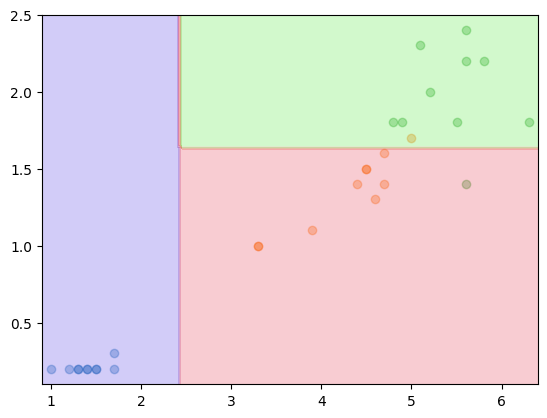

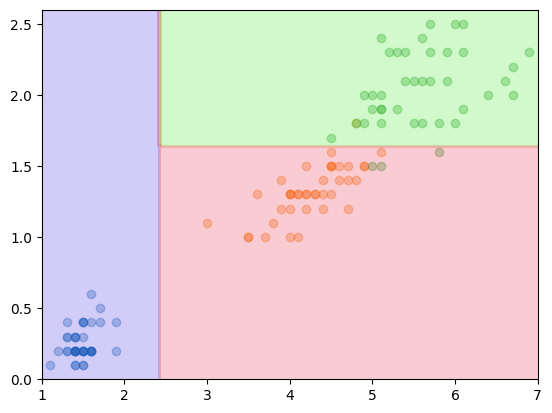

 feature: 0
   feature: 1
     answer: 2 n=38
     answer: 1 n=42
   answer: 0 n=40


In [110]:
class DecisionTree(BaseEstimator, ClassifierMixin):
  def __init__(self, min_samples_leaf=2, max_depth=100):
    self.min_samples_leaf = min_samples_leaf
    self.max_depth = max_depth

  def fit(self, X, y):
    self.feature, self.value, self.imp  = best_feature(X, y)
    greater_values = X[:, self.feature] >= self.value
    if sum(greater_values)>=self.min_samples_leaf and \
       sum(~greater_values)>=self.min_samples_leaf and \
       self.max_depth > 0:
      self.greaters = DecisionTree(min_samples_leaf=self.min_samples_leaf,
                                   max_depth=self.max_depth-1).fit(X[greater_values], y[greater_values])
      self.lessers = DecisionTree(min_samples_leaf=self.min_samples_leaf,
                                   max_depth=self.max_depth-1).fit(X[~greater_values], y[~greater_values])
    else:
      self.n_samples = len(y)
      self.answer = most_common(y)
    return self

  def predict(self, X):
    if hasattr(self, 'answer'):
      return np.array([self.answer] * len(X))
    else:
      greater_values = X[:, self.feature] >= self.value
      return np.where(greater_values, self.greaters.predict(X), self.lessers.predict(X))

model = DecisionTree(max_depth=2)
model.fit(X_train, y_train)
ypred = model.predict(X_test)
print(accuracy_score(y_test, ypred))
plot_dataset(X_test, y_test)
plotPredictions(model, X_test)
plt.show()
plot_dataset(X_train, y_train)
plotPredictions(model, X_train)
plt.show()
print_tree(model)